In [ ]:

import numpy as np
import os
import librosa
!pip install soundfile
import soundfile as sf 
!nvidia-smi
import matplotlib.pyplot as plt
import librosa.display
from torch.utils import data
from torch.utils.data import Dataset
!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 torchaudio===0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
import torchaudio
torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False
import torch
from torch import nn

from sklearn.model_selection import train_test_split

Wed Dec 16 07:08:20 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

/usr/local/lib/python3.6/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [ ]:
torch.cuda.is_available()


True

In [ ]:
cuda = torch.device('cuda')

In [ ]:
train_dataset = torchaudio.datasets.LIBRISPEECH("./", url="train-clean-100", download=True)
test_dataset = torchaudio.datasets.LIBRISPEECH("./", url="test-clean", download=True)

In [ ]:
# Functions for mapping the labels to and from int arrays
def map_char_to_int(char):
  if char == "'":
    return 0
  elif char == " ":
    return 1
  else:
    return ord(char) - 95

def map_int_to_char(num):
  if num == 0:
    return "'"
  elif num == 1:
    return " "
  else:
    return chr(int(num + 95))

def text_to_int_array(text):
  output = []
  for char in text:
    output.append(map_char_to_int(char))
  return output

def int_array_to_text(ints):
  output = ""
  for num in ints:
    output += map_int_to_char(num)
  return output

In [ ]:
mel_spectrogram = torchaudio.transforms.MelSpectrogram()

# Take a sample input of waveforms, and convert them to mel spectrograms
def process_data(data):
    spectograms = []
    labels = []
    spectogram_lengths = []
    label_lengths = []
    for waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id in data:
      # Convert the waveform to a mel spectrogram and the label to a int array
      mel = mel_spectrogram(waveform).squeeze(0).transpose(0, 1)
      spectograms.append(mel)
      labels.append(torch.Tensor(text_to_int_array(utterance.lower())).cuda())
      
      spectogram_lengths.append(mel.shape[0])
      label_lengths.append(len(text_to_int_array(utterance)))

    # Pad sequences so they can be used as a batch for the model input.
    specs = nn.utils.rnn.pad_sequence(spectograms, batch_first=True)
    labs = nn.utils.rnn.pad_sequence(labels, batch_first=True)
    return specs, labs, spectogram_lengths, label_lengths

/usr/local/lib/python3.6/dist-packages/torchaudio/functional.py:318: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


In [ ]:
batch_size = 20


train_loader = data.DataLoader(dataset=train_dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            collate_fn=process_data,
                            drop_last=True)

test_loader = data.DataLoader(dataset=test_dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            collate_fn=process_data,
                            drop_last=True)

/usr/local/lib/python3.6/dist-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/usr/local/lib/python3.6/dist-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)
/usr/local/lib/python3.6/dist-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your samplin

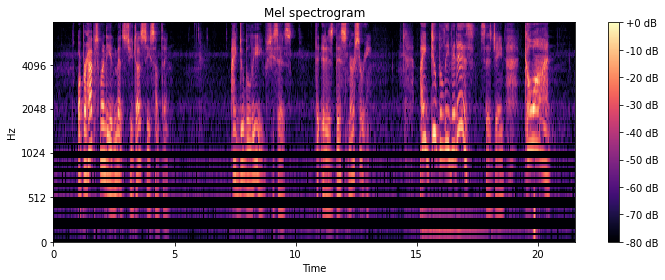

In [ ]:
S = librosa.feature.melspectrogram(S=mel_spectrogram(train_dataset.__getitem__(245)[0]).squeeze(0).numpy())

plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S,ref=np.max),y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

In [ ]:
class DeepSpeechModel(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, dropout_prob):
        super(DeepSpeechModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.dropout_prob = dropout_prob

        # Non Recurrent Layers
        # The hardtanh is used as a clipped relu, as it's not possible otherwise in torch
        self.linear_layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Hardtanh(0, 20, inplace=True),
            nn.Dropout(p=self.dropout_prob),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Hardtanh(0, 20, inplace=True),
            nn.Dropout(p=self.dropout_prob),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.Hardtanh(0, 20, inplace=True),
            nn.Dropout(p=self.dropout_prob),
        )
        
        # Recurrent layer
        self.recurrence = nn.RNN(input_size = hidden_dim * 2, hidden_size = hidden_dim, bidirectional=True, batch_first=True)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim * 2, hidden_dim)
        self.hardtanh = nn.Hardtanh(0,20)
        self.dropout = nn.Dropout(p=self.dropout_prob)

        #Output layer
        self.output = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, hidden):
        
        out = self.linear_layers(x)
        # Passing in the input and hidden state into the model and obtaining outputs
        out, _ = self.recurrence(out, hidden)
        
        #print(hidden)
        out = self.fc(out)
        out = self.hardtanh(out)
        out = self.dropout(out)
        return self.output(out)
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros
        hidden = torch.zeros(2, batch_size, self.hidden_dim)
        return hidden

In [ ]:
#training
device = torch.device("cuda")
#Output dim is 29 to account for blank character
model = DeepSpeechModel(input_dim=128, output_dim=29, hidden_dim=512, dropout_prob=.1)
model.cuda()

num_epochs = 9
lr = 0.0003

# Blank = 28 means that the 28th index in the output represents the blank character for ctcloss
criterion = nn.CTCLoss(blank=28, zero_infinity=True).to(device)

optimizer = torch.optim.SGD(params=model.parameters(), lr=lr, momentum=.99, nesterov=True)

softmax = nn.functional.log_softmax

losses = []
losses_epochs = []
for epoch in range(num_epochs):
    losses_epoch = []
    for batch_id, _data in enumerate(train_loader):
        
        spectogram_batch, label_batch, spectogram_lengths, label_lengths = _data
        spectogram_batch, label_batch = spectogram_batch.cuda(), label_batch.cuda()
        init_hidden = model.init_hidden(batch_size).cuda()
        output = model(spectogram_batch, init_hidden)
        output = softmax(output, dim = 2)
        output = output.transpose(0, 1)
        loss = criterion(output, label_batch, spectogram_lengths, label_lengths)
        optimizer.zero_grad()
        loss.backward()
        if batch_id % 50 == 0:
          print(f"Epoch Num: {epoch} Batch num: {batch_id} Loss: {loss.item()}")
        losses_epoch.append(loss.item())
        losses.append(loss.item())
        optimizer.step()
        
    avg_loss = sum(losses_epoch) / len(losses_epoch)
    print(f'Epoch num: {epoch} Average Loss: {avg_loss}')
    losses_epochs.append(avg_loss)

Epoch Num: 0 Batch num: 0 Loss: 15.3702392578125
Epoch Num: 0 Batch num: 50 Loss: 3.8554527759552
Epoch Num: 0 Batch num: 100 Loss: 4.0333170890808105
Epoch Num: 0 Batch num: 150 Loss: 3.123952865600586
Epoch Num: 0 Batch num: 200 Loss: 3.0997159481048584
Epoch Num: 0 Batch num: 250 Loss: 3.1783406734466553
Epoch Num: 0 Batch num: 300 Loss: 3.0218331813812256
Epoch Num: 0 Batch num: 350 Loss: 3.0081002712249756
Epoch Num: 0 Batch num: 400 Loss: 2.8844709396362305
Epoch Num: 0 Batch num: 450 Loss: 2.9038965702056885
Epoch Num: 0 Batch num: 500 Loss: 2.885146141052246
Epoch Num: 0 Batch num: 550 Loss: 2.8661835193634033
Epoch Num: 0 Batch num: 600 Loss: 2.850855588912964
Epoch Num: 0 Batch num: 650 Loss: 2.8584144115448
Epoch Num: 0 Batch num: 700 Loss: 2.8563475608825684
Epoch Num: 0 Batch num: 750 Loss: 2.8778417110443115
Epoch Num: 0 Batch num: 800 Loss: 2.8715527057647705
Epoch Num: 0 Batch num: 850 Loss: 2.866788625717163
Epoch Num: 0 Batch num: 900 Loss: 2.85127329826355
Epoch Num:

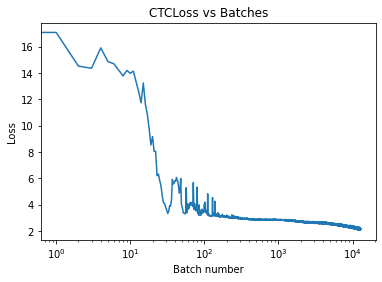

In [ ]:
plt.plot(losses)
plt.xscale("log")
plt.xlabel("Batch number")
plt.ylabel("Loss")
plt.title("CTCLoss vs Batches")
plt.show()

In [ ]:
# Save a created model
from google.colab import files
torch.save(model.state_dict(), 'checkpoint.pth')
files.download('checkpoint.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Load in a presaved model
model = DeepSpeechModel(input_dim=128, output_dim=29, hidden_dim=512, dropout_prob=.1)
state_dict = torch.load('./9epochmodel.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
# This method uses the argmax to find the most likely sequence of characters from a set of probabilities, and removes repeated characters.
def greedy_decode(output, labels, label_lengths):
    arg_maxes = torch.argmax(output, dim=2)
    decoded = []
    output_labels = []
    for i, args in enumerate(arg_maxes):
        decode = []
        output_labels.append(int_array_to_text(labels[i][:label_lengths[i]].tolist()))
        for j, index in enumerate(args):
            if index != 28 and (j != 0 or index == args[j -1]):
               decode.append(index.item())
        decoded.append(int_array_to_text(decode))
    return decoded, output_labels

In [ ]:
model.cuda()
softmax = nn.functional.log_softmax

for batch_id, _data in enumerate(test_loader):
        
        spectogram_batch, label_batch, spectogram_lengths, label_lengths = _data
        spectogram_batch, label_batch = spectogram_batch.cuda(), label_batch.cuda()
    
        init_hidden = model.init_hidden(batch_size).cuda()
        output = model(spectogram_batch, init_hidden)
        output = softmax(output, dim = 2)
        decoded_output, output_labels = greedy_decode(output, label_batch, label_lengths)
        print("Ground Truth Label:")
        print(output_labels[0])
        print("Model Output:")
        print(decoded_output[0], "\n")
        torch.cuda.empty_cache()

/usr/local/lib/python3.6/dist-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/usr/local/lib/python3.6/dist-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


Ground Truth Label:
that's the way with you that's the road you'd all like to go headlongs to ruin
Model Output:
bas se   i  tas t o o o e  a o ton 

Ground Truth Label:
this differentiation is furthered by the inheritance of wealth and the consequent inheritance of gentility
Model Output:
thes to fenso as fe he fote masenfe fo an t cann  pann  on ma te  tonntese 

Ground Truth Label:
after this disappointment i never dare reckon with certainty on the enjoyment of a pleasure again it seems as if some fatality stood between you and me
Model Output:
a i ess os  e caann  a moa do bo ane a si e  an an bon anan e f o an e   a a  san  te  ses ea 

Ground Truth Label:
she was dressed in the regulation costume of the maids at elmhurst a plain black gown with white apron and cap
Model Output:
se e cossto te me  eto e os to at te te o a as  ata  bot  ca  a e  bo fet te  an co 

Ground Truth Label:
you'll never dig it out of the astor library
Model Output:
an  mate  te i at e ase wobe 

Ground Tr